In [1]:
%matplotlib inline
from math import pi, sqrt
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from scipy.special import jv

def radial_plotter(r,x, *, ax=None, fmt='c', title="", xlabel="r", ylabel="v"):
    '''Plot x assuming it is symmetric about the r=0 line'''
    if ax is None:
        ax = plt
    
    ax.plot(-r, x, fmt)
    ax.plot(r, x, fmt)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    


## Equation setup 

In [2]:
# code parameters
Ns = 100 # radial resolution
Nt = 50  # number of time levels
Np = 1   # number of periods
Tmin = 0.0

# physical parameters
a = 0.5e-2   # pipe radius, m
mu = 1.05e-3 # dynamic viscocity, Pa*s
rho = 1e3    # density

def compute_Tmax(Tmin, Np, alpha):
    omega = (alpha/a)**2 * mu/rho
    f = omega/(2*pi)
    T = 1/f
    Tmax = Tmin + T*Np
    return Tmax
    

def J0(z): return jv(0, z)

def J1(z): return jv(1, z)

def v_hat(r, dp_dz_hat, *, a, alpha, omega, rho):
    p1 = 1j**1.5*alpha
    p2 = 1 - (J0(p1*r/a)/J0(p1))
    return 1j/(rho*omega)*dp_dz_hat*p2

def v(r, t, dp_dz_hat, *, a, alpha, omega, rho):
    v_h = v_hat(r, dp_dz_hat, a=a, alpha=alpha, omega=omega, rho=rho)
    v_h = np.reshape(v_h, (-1,1))
    exp = np.reshape(np.exp(1j*omega*t), (-1,1))
    
    return np.real(v_h*exp.T)

def compute_profile(r, t, *, a, alpha, p0, Ns=Ns):
    dp_dz_hat = p0
    
    omega = (alpha/a)**2 * mu/rho
    profile = v(r, t, dp_dz_hat,
                a=a, alpha=alpha, omega=omega, rho=rho)
    
    #print(f"Creating profile for alpha = {alpha:0.3f}")
    return profile

## Task a

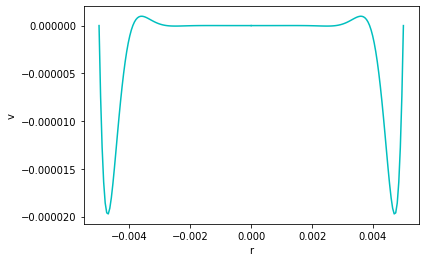

In [3]:
alpha = 20.0
Tmax = compute_Tmax(Tmin, Np, alpha)

r = np.linspace(0,a, num=Ns)
t = np.linspace(Tmin, Tmax, num=Nt)

profile = compute_profile(r, t, a=a, alpha=alpha, p0=1.0)

# Draw profile at time 0
profile_0 = profile[:,0]
radial_plotter(r, profile_0, ax=plt.axes(), title="Profile at t=0")


## Task b

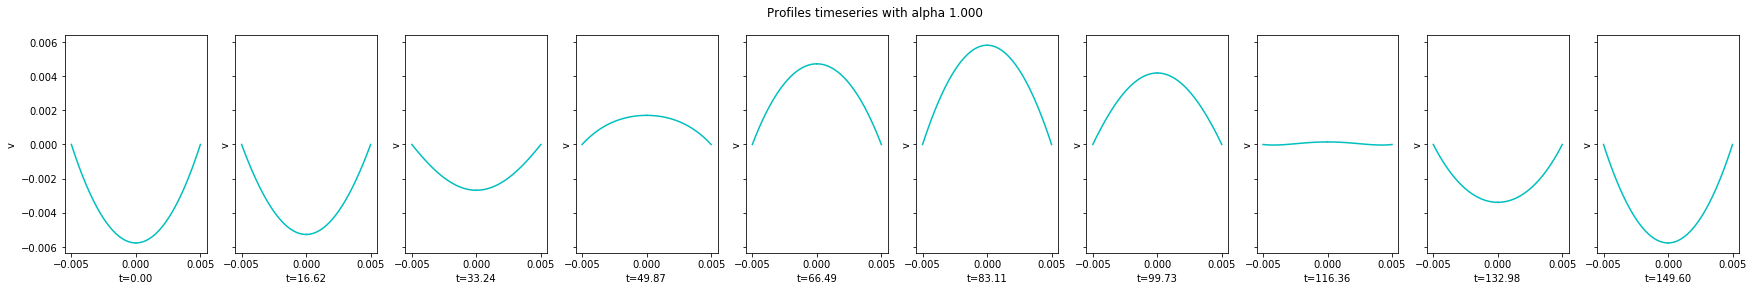

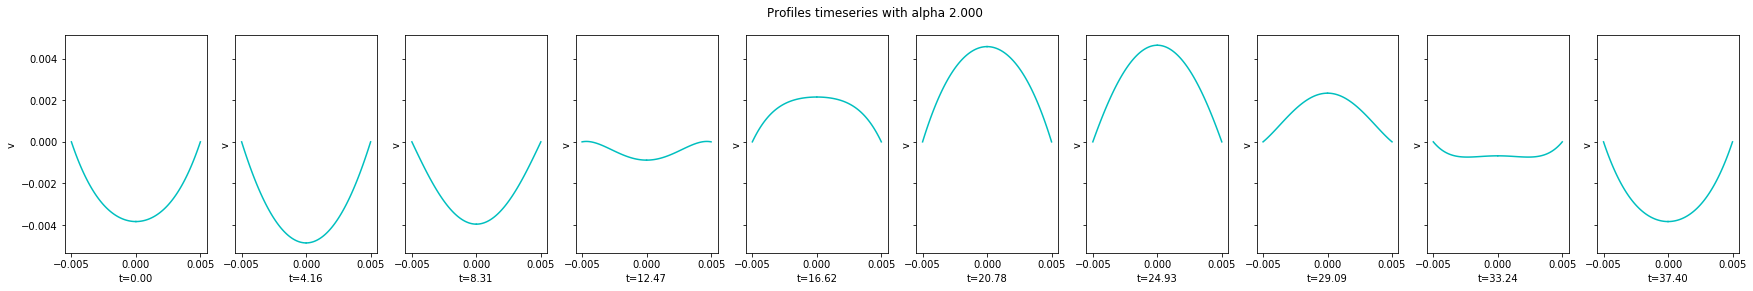

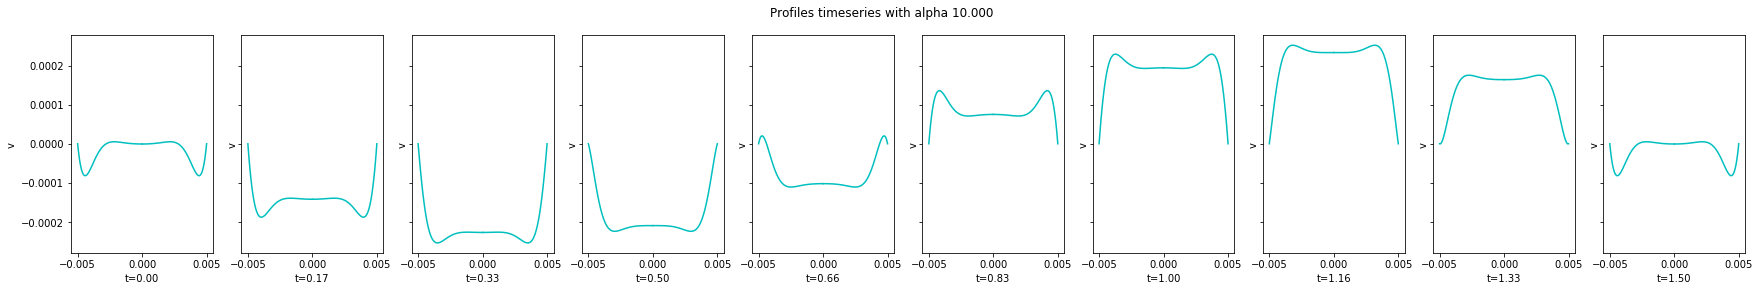

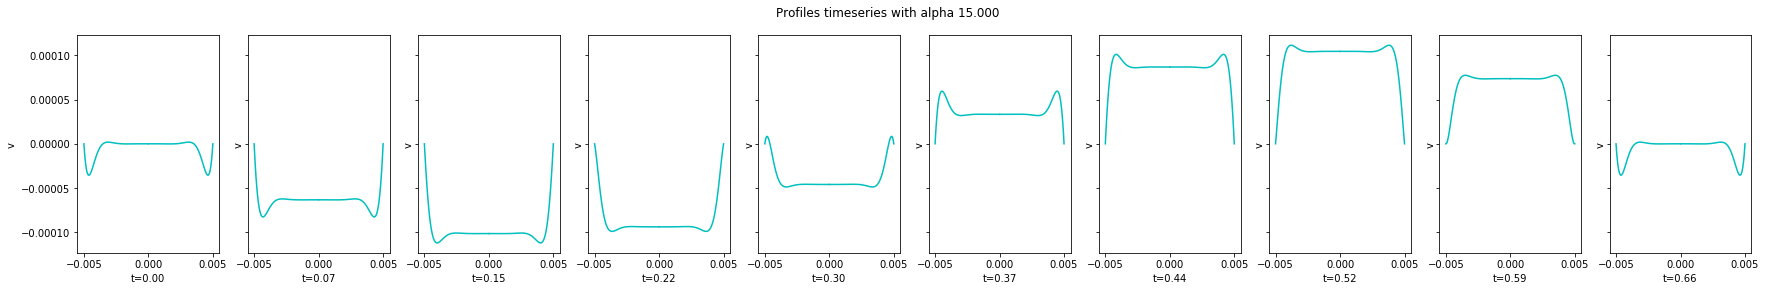

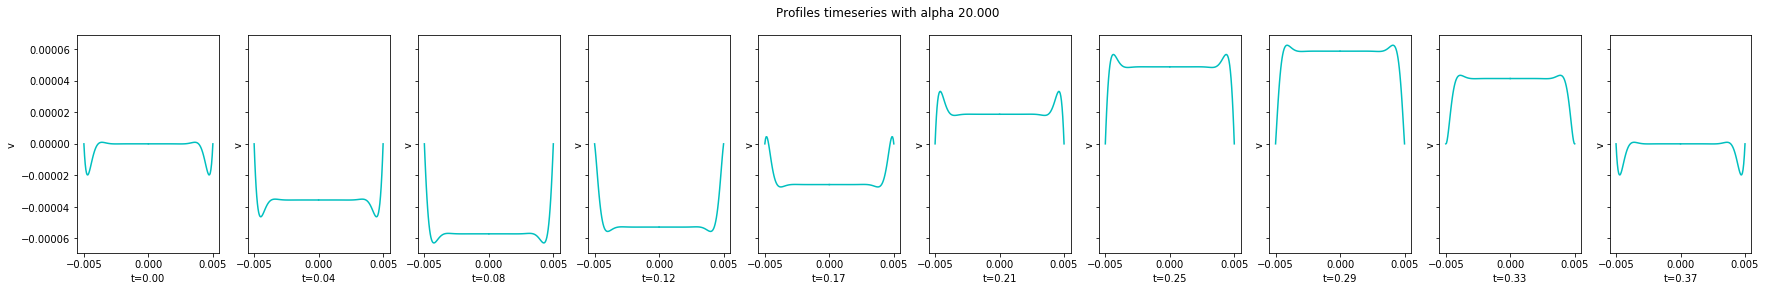

In [4]:
Nt_plot = 10 # how many plots per womsley number
womsley_numbers = [1, 2, 10, 15, 20]

for alpha in womsley_numbers:
    # Compute velocity profile
    Tmax = compute_Tmax(Tmin, Np, alpha)
    t = np.linspace(Tmin, Tmax, num=Nt)
    profile = compute_profile(r, t, a=a, alpha=alpha, p0=1.0)
    
    # Plot a series of velocity plots
    fig, axs = plt.subplots(1, Nt_plot, sharey=True)
    fig.suptitle(f"Profiles timeseries with alpha {alpha:0.3f}")
    fig.set_figwidth(3*Nt_plot)

    t_plot = np.linspace(Tmin, Tmax, Nt_plot)
    for ax, i in zip(axs, range(len(t_plot))):
        t0 = t_plot[i]
        profile_t_index = int((t0 - Tmin)/(Tmax - Tmin)*(Nt-1))
        v0 = profile[:, profile_t_index]

        radial_plotter(r, v0, 
                       ax=ax, title="", 
                       xlabel=f"t={t0:0.2f}")
    plt.show()

## Task d

At the wall of the pipe, the slope of the velocity profile tells us how strong the wall shear stress, since the formula is
$$\tau_w = -\mu \frac{\partial v}{\partial r}\vert_a$$

In the plots above we see that the higher Womersley numbers give higher slopes at the wall, so higher Womersley number give higher wall shear stress.

## Task e

$$
\frac{\partial v}{\partial r} = \frac{\partial}{\partial r} Re\left[ \frac{i}{\rho\omega} \frac{\partial \hat{p}}{\partial z} e^{i\omega t}
                        \left( 1 - \frac{J_0(i^{3/2}\alpha r / a)}{J_0(i^{3/2}\alpha)}    \right)
\right]
$$

$r$ only shows up inside the top $J_0(...)$ so we can simplify quite alot.

$$
\frac{\partial v}{\partial r} = Re\left[ - \frac{i}{\rho\omega} \frac{\partial \hat{p}}{\partial z} e^{i\omega t}
                         \frac{1}{J_0(i^{3/2}\alpha)} \frac{\partial J_0(i^{3/2}\alpha r / a)}{\partial r}
\right]
$$

Using the chain rule and the provided formula we have
$$
\frac{\partial J_0(i^{3/2}\alpha r / a)}{\partial r} = -J_1(i^{3/2}\alpha r / a) i^{3/2}\alpha / a
$$

Inserting into the above expression and simplifying we get
$$
\frac{\partial v}{\partial r} = Re\left[ \frac{i^{5/2} \alpha}{\rho\omega a} \frac{\partial \hat{p}}{\partial z} e^{i\omega t}
                         \frac{J_1(i^{3/2}\alpha r / a)}{J_0(i^{3/2}\alpha)} 
\right]
$$

At the wall this expression reduces to
$$
\frac{\partial v}{\partial r} = Re\left[ \frac{i^{5/2} \alpha}{\rho\omega a} \frac{\partial \hat{p}}{\partial z} e^{i\omega t}
                         \frac{J_1(i^{3/2}\alpha)}{J_0(i^{3/2}\alpha)} 
\right]
$$

So the wall shear stress is then
$$
\tau_w = -\mu Re\left[ \frac{i^{5/2} \alpha}{\rho\omega a} \frac{\partial \hat{p}}{\partial z} e^{i\omega t}
                         \frac{J_1(i^{3/2}\alpha)}{J_0(i^{3/2}\alpha)} 
\right]
$$


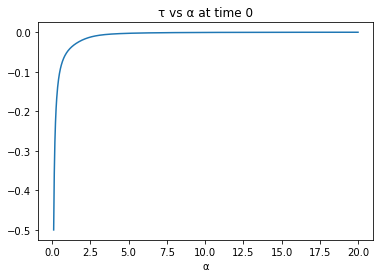

In [5]:
alphas = np.linspace(0.1, 20, 1000)
omegas = (alphas/a)**2 * mu/rho
dp_dz_hat = 1.0


t = 0
exp = np.exp(1j*omegas*t)
J_frac = J1(1j**(3/2)*alphas) / J0(1j**(3/2)*alphas)
tau_w = -mu * np.real( 1j**(5/2)*alpha/(rho*omegas*a)*exp.T*J_frac)

plt.plot(alphas, tau_w)
plt.xlabel("α")
plt.title(f"τ vs α at time {t}")
plt.show()
